# Соотношения доли переданной информации и энергозатраты (Монте-Карло)

По материалам статьи:

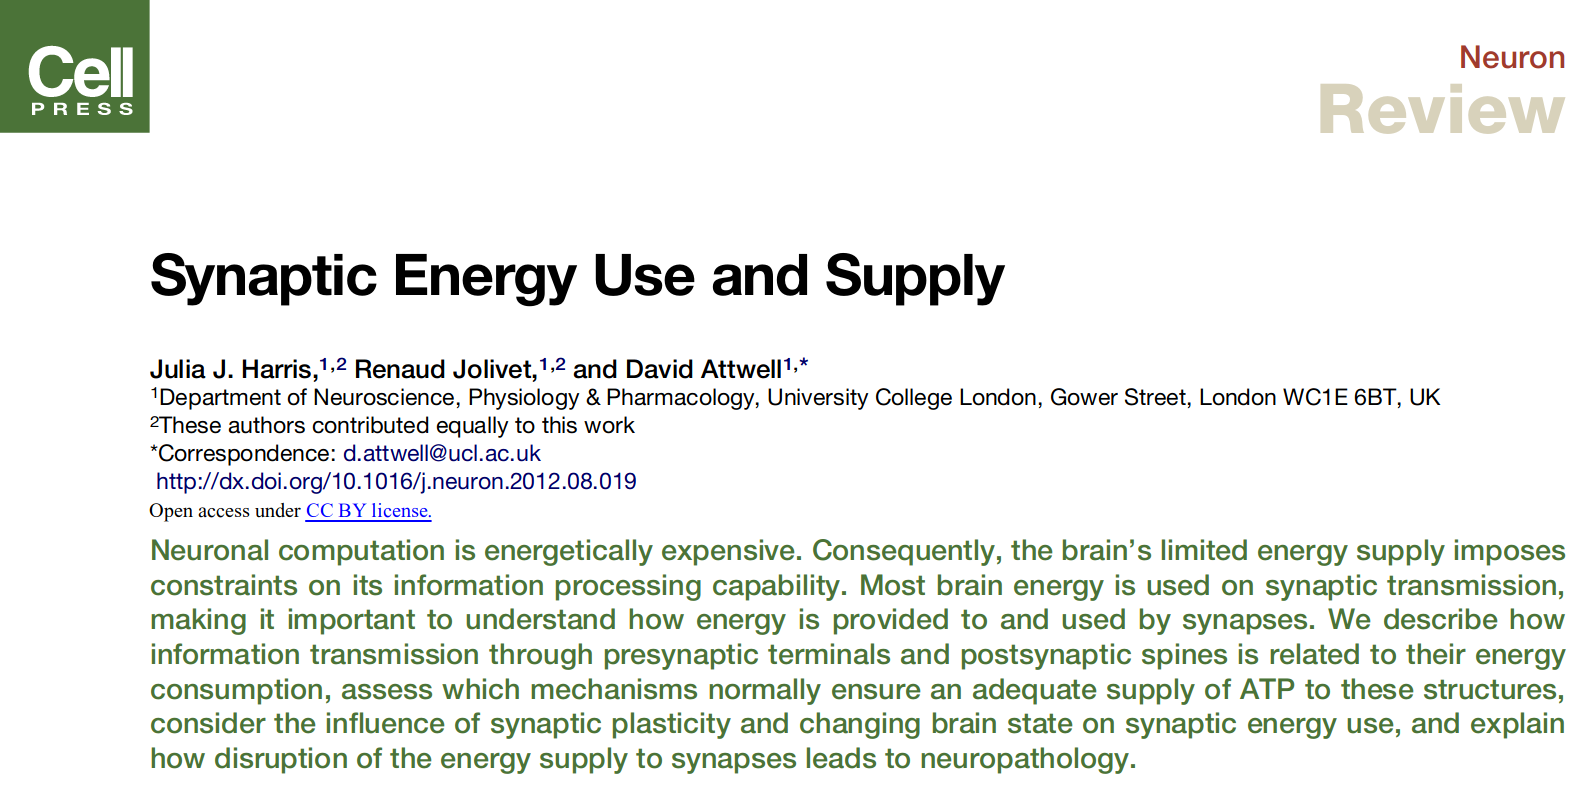

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl

from matplotlib.pyplot import colorbar, close, figure, gca, gcf, imshow, plot, setp, subplots
from matplotlib.pyplot import title, suptitle, ylabel, xlabel, xlim, ylim
from matplotlib.pyplot import legend


In [3]:
plt.style.use(['ggplot','seaborn-v0_8-muted'])
mpl.rc('figure', figsize=(9,9*0.618), dpi=150)

In [4]:

import numpy as np
from numpy import linalg


# import most often used functions
from numpy import array, arange, clip, ones, percentile, where, zeros
from numpy import exp, tanh, log, log2, linspace

from numpy.linalg import svd
from numpy.random import permutation, rand

In [5]:
from numba import jit

Взаимная информация:
\begin{equation}
I_m = -\sum_rP[s]\log_2P [s] + \sum_{r,s}P[r]P[s|r]\log_2 P[s|r]
\end{equation}


\begin{equation}
I_m = \sum_{s,r}P[r,s]\log_2\frac{P[r,s]}{P[r]P[s]}
\end{equation}

## Один синапс на нейрон

In [6]:
@jit(nopython=True)
def model_Hnoise(s,r,Ntrials=1e6):
    responses = zeros((2,2))
    for i in range(int(Ntrials)):
        if rand() < s: # spike arrived
            row = 1
            col = (rand() < r) and 1 or 0
        else :
            row,col = 0,0
        responses[row, col] +=1
    
    probs =  responses/Ntrials
    Prs = np.sum(probs, 0)
    Pss = np.sum(probs, 1)
    acc = 0
    for row in [0,1]:
        for col in [0,1]:
            Prs_joint = probs[row,col]
            # skipping zero probabilities to avoid numerical errors...
            if Prs_joint*Prs[col]*Pss[row] > 0:
                acc += Prs_joint*log2(Prs_joint/(Prs[col]*Pss[row]))
    Iinp = -sum(Pss*log2(Pss))
    return acc/Iinp # доля переданной информации!
            

In [7]:
%time model_Hnoise(0.5,0.9,Ntrials=1e7)

CPU times: user 2.35 s, sys: 38.6 ms, total: 2.39 s
Wall time: 2.39 s


0.7585875192437085

In [8]:
sx = 0.01
rv = linspace(0.01,1.0)
sv = [0.01, 0.1, 0.5, 0.95, 0.99]
%time yx = [[model_Hnoise(s,r, Ntrials=1e7) for r in rv] for s in sv]

CPU times: user 27.8 s, sys: 10.9 ms, total: 27.8 s
Wall time: 27.8 s


Text(0.5, 0.98, 'Моносинаптическая связь')

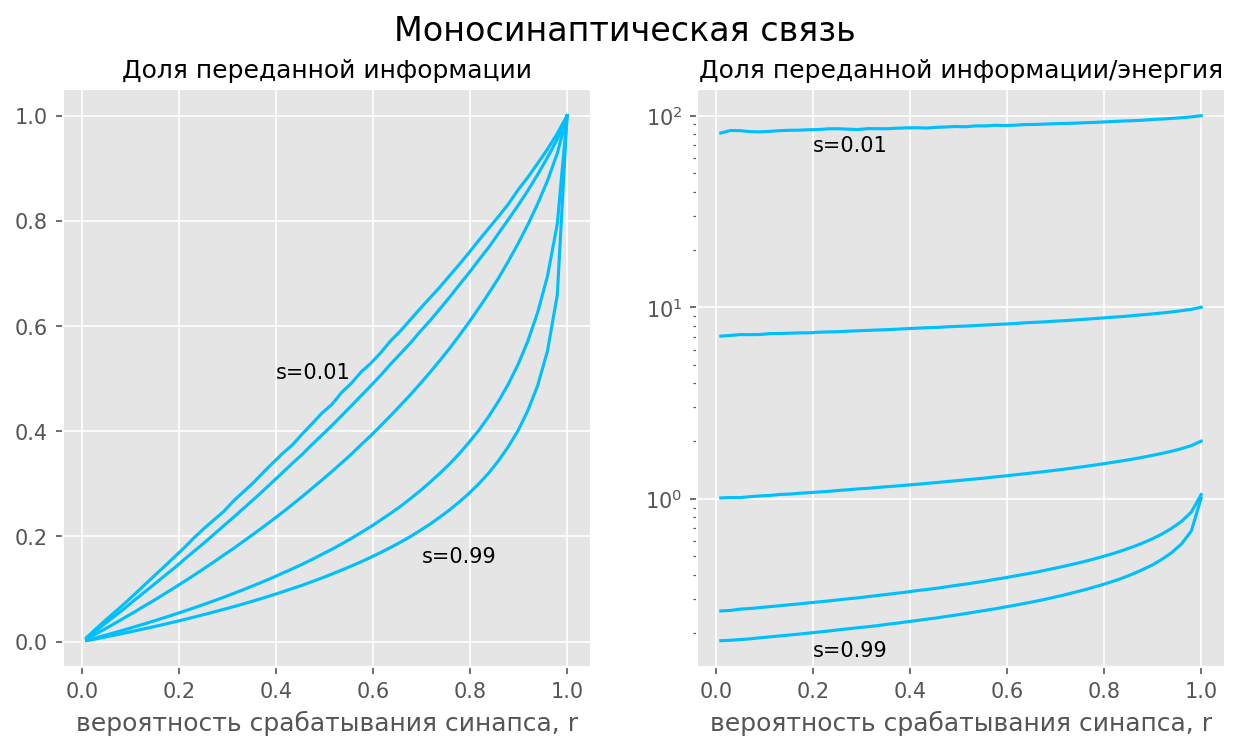

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
for y,s in zip(yx,sv):
    axs[0].plot(rv, y, color='deepskyblue')
    axs[1].semilogy(rv, y/(s*rv), color='deepskyblue')


axs[0].text(0.4, 0.5, "s=0.01")
axs[0].text(0.7, 0.15, "s=0.99")


axs[1].text(0.2, 65, "s=0.01")
axs[1].text(0.2, 0.15, "s=0.99")


axs[0].set_title(u"Доля переданной информации",size=12)
axs[1].set_title(u"Доля переданной информации/энергия",size=12)
axs[0].set_xlabel(u'вероятность срабатывания синапса, r')
axs[1].set_xlabel(u'вероятность срабатывания синапса, r')
plt.suptitle(u"Моносинаптическая связь", size=16)

## Полисинаптическая связь со спонтанным выбросом

In [10]:
@jit(nopython=True)
def model_Hnoise_poly(s,r,Nsyn=10, spont=0.003, Ntrials=1e6):
    "Здесь наличие хотя бы одного ВПСП рассматривается как передача события"
    responses = zeros((2,2))
    for i in range(int(Ntrials)):
        row, col = 0,0
        if rand() < s: # spike arrived
            row = 1
            # probability of at least one release:
            if rand() >= (1-r)**Nsyn:
                col = 1
        # handle spontaneous release
        if rand() >= (1-spont)**Nsyn:
            col = 1 
        responses[row, col] +=1
    #
    probs =  responses/Ntrials
    Prs = np.sum(probs, 0)
    Pss = np.sum(probs, 1)
    acc = 0
    for row in [0,1]:
        for col in [0,1]:
            Prs_joint = probs[row,col]
            # skipping zero probabilities to avoid numerical errors...
            if Prs_joint*Prs[col]*Pss[row] > 0:
                acc += Prs_joint*log2(Prs_joint/(Prs[col]*Pss[row]))
    Iinp = -sum(Pss*log2(Pss))
    return acc/Iinp # доля переданной информации!

In [11]:
%time yx10 = [[model_Hnoise_poly(0.01,r,n,Ntrials=1e7) for r in rv] for n in [1,2,4,10]]

CPU times: user 24.6 s, sys: 3.95 ms, total: 24.7 s
Wall time: 24.7 s


Text(0.5, 0.98, 'Полисинаптическая связь и спонтанный выброс')

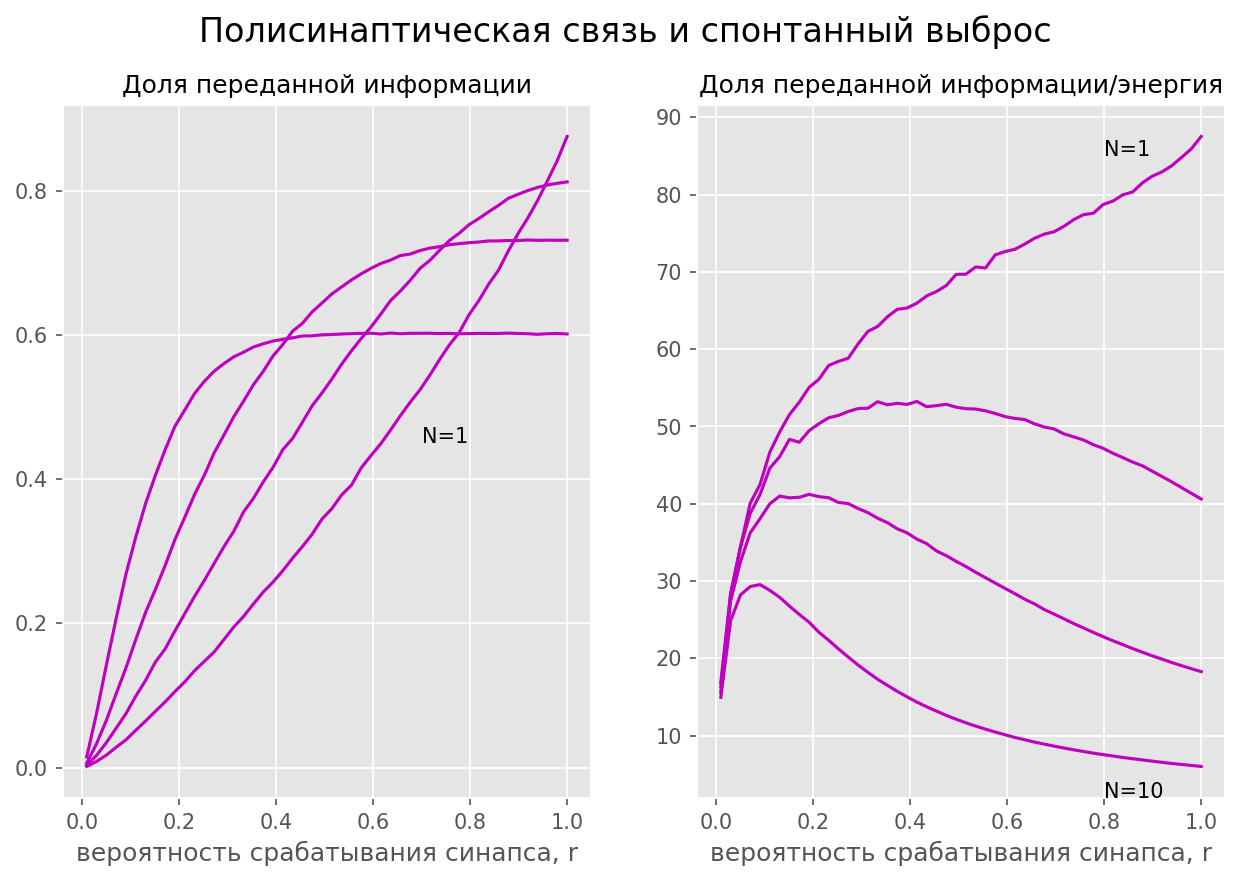

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
s = 0.01
for y,n in zip(yx10, [1,2,4,10]):
    axs[0].plot(rv, y, color='m')
    axs[1].plot(rv, y/(s*n*rv), color='m')

#axs[0].text(0.1, 0.85, "N=10")
axs[0].text(0.7, 0.45, "N=1")
    
axs[1].text(0.8, 85, "N=1")
axs[1].text(0.8, 2, "N=10")

axs[0].set_title(u"Доля переданной информации",size=12)
axs[1].set_title(u"Доля переданной информации/энергия",size=12)
axs[0].set_xlabel(u'вероятность срабатывания синапса, r')
axs[1].set_xlabel(u'вероятность срабатывания синапса, r')
plt.suptitle(u"Полисинаптическая связь и спонтанный выброс", size=16)